### In this code, we will develop a GAN model, particularly ACGAN, which can generate (synthesize) chest X-ray images based on the given input images of healthy (normal) and sick (pneumonia) patients.

In [1]:
### Import the required libraries
import numpy as np
import tensorflow as tf
from keras.datasets import mnist
import cv2
import os
import pathlib
from keras.layers import Conv2D, Conv2DTranspose, Dropout, Dense, Reshape, LayerNormalization, LeakyReLU
from keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        """
        Initialize the ReadDataset object.

        Args:
            datasetpath (str): Path to the dataset directory.
            labels (list): List of labels.
            image_shape (tuple): Tuple specifying the shape of the images.
        """
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape
    
    def returListImages(self,):
        """
        Get a list of images for each label.
        """
        self.images = []
        for label in self.labels:
            self.images.append(list(pathlib.Path(os.path.join(self.datasetpath, label)).glob('*.*')))
    
    def readImages(self,):
        """
        Read and preprocess images.
        Returns:
            images (numpy.ndarray): Array of preprocessed images.
            labels (numpy.ndarray): Array of corresponding labels.
        """
        self.returListImages()
        self.finalImages = []
        labels = []
        for label in range(len(self.labels)):
            for img in self.images[label]:
                img = cv2.imread(str(img))
                img = cv2.resize(img , self.image_shape)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img  = img/255        ## helps in stabilizing the learning process during training
                self.finalImages.append(img)
                labels.append(label)
        images = np.array(self.finalImages)
        labels = np.array(labels)
        return images, labels

In [3]:
# Instantiate ReadDataset object with dataset path, labels, and image shape
readDatasetObject = ReadDataset('/kaggle/input/chest-xray-pneumonia/chest_xray/train', ['NORMAL', 'PNEUMONIA'], (64, 64))

# Read and preprocess images
images, labels = readDatasetObject.readImages()

In [4]:
images.shape, labels.shape

((5216, 64, 64, 3), (5216,))

In [5]:
# import numpy as np
# from sklearn.utils import shuffle
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# def augment_data(images, labels, batch_size=64, augmentation_factor=1):
#     datagen = ImageDataGenerator(
#         rotation_range=10,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         shear_range=0.1,
#         zoom_range=0.1,
#         horizontal_flip=True,
#         fill_mode='nearest'
#     )

#     augmented_images = []
#     augmented_labels = []

#     # Reshape labels to match the shape of augmented images
#     labels = np.expand_dims(labels, axis=-1)

#     for img, label in zip(images, labels):
#         img = np.expand_dims(img, axis=0)
#         label = np.expand_dims(label, axis=0)
#         for _ in range(augmentation_factor):
#             augmented_img, augmented_label = next(datagen.flow(img, label, batch_size=1))
#             augmented_images.append(augmented_img[0])
#             augmented_labels.append(augmented_label[0])

#     augmented_images = np.array(augmented_images)
#     augmented_labels = np.array(augmented_labels)

#     # Combine original and augmented data
#     combined_images = np.concatenate((images, augmented_images), axis=0)
#     combined_labels = np.concatenate((labels, augmented_labels), axis=0)

#     # Shuffle the combined data
#     combined_images, combined_labels = shuffle(combined_images, combined_labels)

#     return combined_images, combined_labels

# # Example usage:
# images, labels = augment_data(images1, labels1)
# print("Original images shape:", images1.shape)
# print("Augmented images shape:", images.shape)
# print("Original labels shape:", labels1.shape)
# print("Augmented labels shape:", labels.shape)

Original images shape: (5216, 64, 64, 3)
Augmented images shape: (10432, 64, 64, 3)
Original labels shape: (5216,)
Augmented labels shape: (10432, 1)


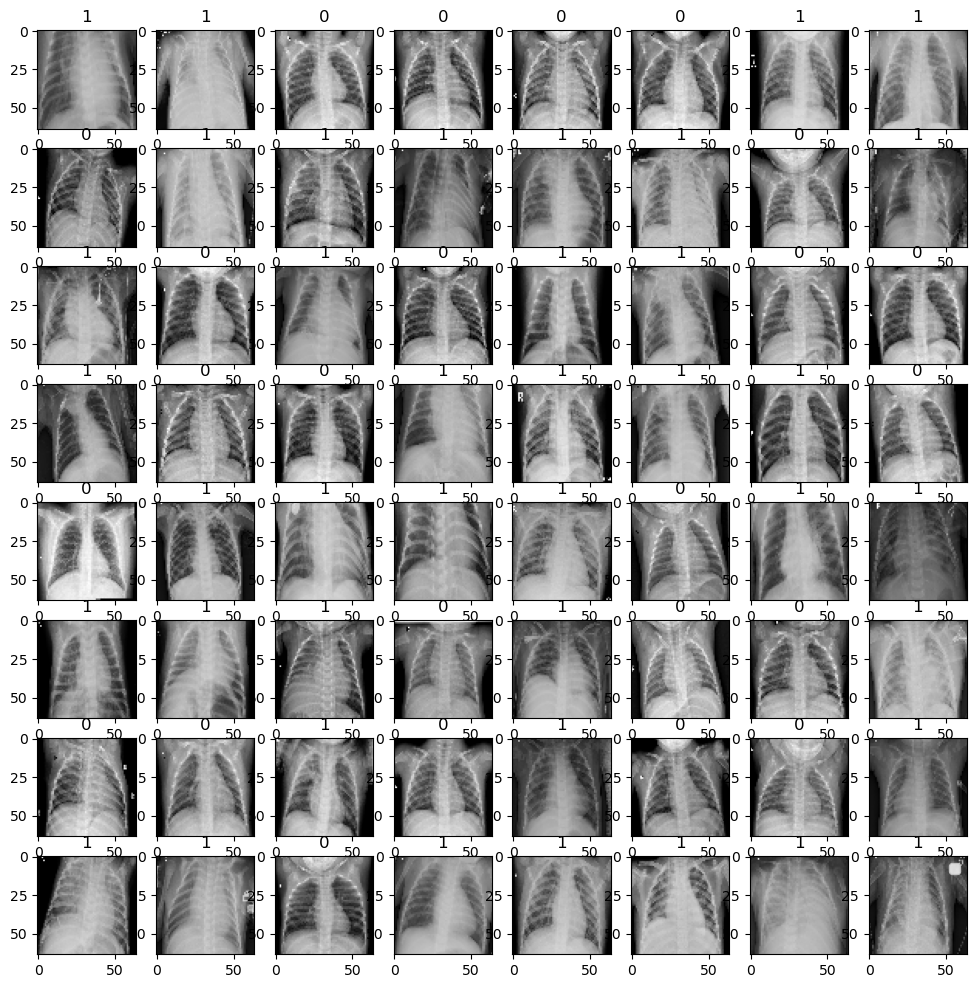

In [5]:
plt.figure(figsize = (12, 12))
indexs = np.random.randint(0, len(labels), size = (64, ))
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(images[indexs[i]])
    plt.title(labels[indexs[i]])
plt.legend()

In [7]:
class Acgan:
    def __init__(self, eta, batch_size, epochs, weight_decay, latent_space,
                 image_shape, kernel_size):
        self.eta = eta
        self.batch_size = batch_size
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.latent_space = latent_space
        self.image_shape = image_shape
        self.kernel_size = kernel_size
    
    def data(self, images, labels):
        ytrain = tf.keras.utils.to_categorical(labels)
        self.images = images
        self.labels = ytrain

    def samples(self, G, noize, labels):
        images = G.predict([noize, labels])
        ys = np.argmax(labels, axis = 1)
        plt.figure(figsize = (12, 4))
        for i in range(16):
            plt.subplot(2, 8, (i + 1))
            plt.imshow(images[i], cmap = 'gray')
            plt.title(ys[i])
        plt.show()
    
    def generator(self, inputs, labels):
        filters = [256, 128, 64, 32]
        padding = 'same'
        x = inputs
        y = labels
        x = layers.concatenate([x, y])
        x = layers.Dense(1024, )(x)
        x = layers.Dense(8*8*filters[0],
                         kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        x = layers.Reshape((8, 8, filters[0]))(x)
        for filter in filters:
            if filter >= 64:
                strides = 2
            else:
                strides = 1
            x = LayerNormalization()(x)
            x = layers.Activation('relu')(x)
            x = Conv2DTranspose(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides)(x)
        x = Conv2DTranspose(3, kernel_size = self.kernel_size, padding = padding)(x)
        x = layers.Activation('sigmoid')(x)
        self.generatorModel = models.Model(inputs = [inputs, labels],
                                           outputs = x,
                                           name = 'generator')
    
    def discriminator(self, inputs):
        x = inputs
        filters = [32, 64, 128, 256]
        padding = 'same'
        for filter in filters:
            if filter < 256:
                strides = 2
            else:
                strides = 1
            x = Conv2D(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides,
                      kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
            x = LeakyReLU(alpha = 0.2)(x)
        x = layers.Flatten()(x)
        outputs = Dense(1, )(x)
        labelsOutput = Dense(256,
                             kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        labelsOutput = Dropout(0.3)(labelsOutput)
        labelsOutput = Dense(2,)(labelsOutput)
        labelsOutput = layers.Activation('softmax')(labelsOutput)
        self.discriminatorModel = models.Model(inputs = inputs,
                                               outputs = [outputs, labelsOutput],
                                               name = 'discriminator')
    
    def build(self,):
        generatorInput = layers.Input(shape = (self.latent_space))
        discriminatorInput = layers.Input(shape = (self.image_shape))
        labelsInput = layers.Input(shape = (2, ))
        self.generator(generatorInput, labelsInput)
        self.discriminator(discriminatorInput)
        G = self.generatorModel
        D = self.discriminatorModel
        D.compile(loss = ['mse', 'binary_crossentropy'],
                 optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta,
                                                        weight_decay = self.weight_decay))
        D.summary()
        G.summary()
        D.trainable = False
        GAN = models.Model(inputs = [generatorInput, labelsInput],
                           outputs = D(G([generatorInput, labelsInput])))
        GAN.compile(loss = ['mse', 'binary_crossentropy'],
                   optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta*0.5,
                                                          weight_decay = self.weight_decay*0.5))
        GAN.summary()
        return G, D, GAN
  
    def trainAlgorithm(self, G, D, GAN):
        """
        Train the ACGAN model.
        Args:
        - G: generator model
        - D: discriminator model
        - GAN: combined model (generator and discriminator)
        """
        generator_losses = []
        discriminator_losses = []

        for epoch in range(self.epochs):
#             epoch_generator_losses = []
#             epoch_discriminator_losses = []

#             for i in range(len(self.images) // self.batch_size):
#             for i in range(10):
                indexs = np.random.randint(0, len(self.images), size=(self.batch_size,))
#                 indexs = np.arange(i*self.batch_size, (i+1)*self.batch_size)
                realImages = self.images[indexs]
                realLabels = self.labels[indexs]
                realTag = tf.ones(shape=(self.batch_size,))
                noise = tf.random.uniform(shape=(self.batch_size, self.latent_space), minval=-1, maxval=1)
                fakeLabels = tf.keras.utils.to_categorical(np.random.choice(range(2), size=(self.batch_size)), num_classes=2)
                fakeImages = tf.squeeze(G.predict([noise, fakeLabels], verbose=0))
                fakeTag = tf.zeros(shape=(self.batch_size,))
                allImages = np.vstack([realImages, fakeImages])
                allLabels = np.vstack([realLabels, fakeLabels])
                allTags = np.hstack([realTag, fakeTag])
                _, dlossTag, dlossLabels = D.train_on_batch(allImages, [allTags, allLabels])
                noise = tf.random.uniform(shape=(self.batch_size, self.latent_space), minval=-1, maxval=1)
                _, glossTag, glossLabels = GAN.train_on_batch([noise, fakeLabels], [realTag, fakeLabels])
#                 epoch_generator_losses.append([glossTag, glossLabels])
#                 epoch_discriminator_losses.append([dlossTag, dlossLabels])

                generator_losses.append([glossTag, glossLabels])
                discriminator_losses.append([dlossTag, dlossLabels])

                if epoch % 2000 == 0 or epoch == (self.epochs - 1) :
                    print('Epoch: {}'.format(epoch))
                    print('discriminator loss: [tag: {}, labels: {}], generator loss: [tag: {}, labels: {}]'.format(dlossTag, dlossLabels, glossTag, glossLabels))
                    self.samples(G, noise, fakeLabels)

#                     self.plot_losses(generator_losses, discriminator_losses, epoch)

    def plot_losses(self, generator_losses, discriminator_losses, epoch):
        generator_losses = np.array(generator_losses)
        discriminator_losses = np.array(discriminator_losses)
        
        plt.figure(figsize=(12, 6))
        plt.plot(generator_losses[:, 0], label='Generator Tag Loss')
#         plt.plot(generator_losses[:, 1], label='Generator Labels Loss')
        plt.plot(discriminator_losses[:, 0], label='Discriminator Tag Loss')
#         plt.plot(discriminator_losses[:, 1], label='Discriminator Labels Loss')
        plt.xlabel('Number of batches')
        plt.ylabel('Loss')
        plt.title('Generator and Discriminator Losses (Epoch {})'.format(epoch))
        plt.legend()
        plt.show()

In [8]:
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from tensorflow.keras.constraints import Constraint

# class ClipConstraint(Constraint):
#     def __init__(self, clip_value):
#         self.clip_value = clip_value

#     def __call__(self, weights):
#         return tf.clip_by_value(weights, -self.clip_value, self.clip_value)

# class Acwgan:
#     def __init__(self, eta, batch_size, epochs, weight_decay, latent_space,
#                  image_shape, kernel_size, clip_value=0.01):
#         self.eta = eta
#         self.batch_size = batch_size
#         self.epochs = epochs
#         self.weight_decay = weight_decay
#         self.latent_space = latent_space
#         self.image_shape = image_shape
#         self.kernel_size = kernel_size
#         self.clip_value = clip_value
    
#     def data(self, images, labels):
#         ytrain = tf.keras.utils.to_categorical(labels)
#         self.images = images
#         self.labels = ytrain

#     def samples(self, G, noize, labels):
#         images = G.predict([noize, labels])
#         ys = np.argmax(labels, axis = 1)
#         plt.figure(figsize = (12, 4))
#         for i in range(16):
#             plt.subplot(2, 8, (i + 1))
#             plt.imshow(images[i], cmap = 'gray')
#             plt.title(ys[i])
#         plt.show()
    
#     def generator(self, inputs, labels):
#         filters = [256, 128, 64, 32]
#         padding = 'same'
#         x = inputs
#         y = labels
#         x = layers.concatenate([x, y])
#         x = layers.Dense(1024)(x)
#         x = layers.Dense(8*8*filters[0],
#                          kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
#         x = layers.Reshape((8, 8, filters[0]))(x)
#         for filter in filters:
#             if filter >= 64:
#                 strides = 2
#             else:
#                 strides = 1
#             x = layers.Activation('relu')(x)
#             x = layers.Conv2DTranspose(filter, kernel_size=self.kernel_size, padding=padding,
#                                         strides=strides)(x)
#         x = layers.Conv2DTranspose(3, kernel_size=self.kernel_size, padding=padding)(x)
#         x = layers.Activation('sigmoid')(x)
#         self.generatorModel = models.Model(inputs=[inputs, labels],
#                                            outputs=x,
#                                            name='generator')
    
#     def discriminator(self, inputs):
#         x = inputs
#         filters = [32, 64, 128, 256]
#         padding = 'same'
#         for filter in filters:
#             if filter < 256:
#                 strides = 2
#             else:
#                 strides = 1
#             x = layers.Conv2D(filter, kernel_size=self.kernel_size, padding=padding,
#                               strides=strides,
#                               kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
#             x = layers.LeakyReLU(alpha=0.2)(x)
#         x = layers.Flatten()(x)
#         outputs = layers.Dense(1)(x)
#         labelsOutput = layers.Dense(256,
#                                     kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
#         labelsOutput = layers.Dropout(0.3)(labelsOutput)
#         labelsOutput = layers.Dense(2)(labelsOutput)
#         labelsOutput = layers.Activation('softmax')(labelsOutput)
#         self.discriminatorModel = models.Model(inputs=inputs,
#                                                outputs=[outputs, labelsOutput],
#                                                name='discriminator')
    
#     def build(self,):
#         generatorInput = layers.Input(shape=(self.latent_space))
#         discriminatorInput = layers.Input(shape=(self.image_shape))
#         labelsInput = layers.Input(shape=(2,))
#         self.generator(generatorInput, labelsInput)
#         self.discriminator(discriminatorInput)
#         G = self.generatorModel
#         D = self.discriminatorModel
#         D.compile(loss=[self.wasserstein_loss, 'binary_crossentropy'],
#                   optimizer=tf.keras.optimizers.RMSprop(learning_rate=self.eta,
#                                                          clipvalue=self.clip_value))
#         D.summary()
#         G.summary()
#         D.trainable = False
#         GAN = models.Model(inputs=[generatorInput, labelsInput],
#                            outputs=D(G([generatorInput, labelsInput])))
#         GAN.compile(loss=[self.wasserstein_loss, 'binary_crossentropy'],
#                     optimizer=tf.keras.optimizers.RMSprop(learning_rate=self.eta*0.5,
#                                                            clipvalue=self.clip_value))
#         GAN.summary()
#         return G, D, GAN
  
#     def wasserstein_loss(self, y_true, y_pred):
#         return -tf.reduce_mean(y_true * y_pred)

#     def trainAlgorithm(self, G, D, GAN):
#         """
#         Train the ACWGAN model.
#         Args:
#         - G: generator model
#         - D: discriminator model
#         - GAN: combined model (generator and discriminator)
#         """
#         generator_losses = []
#         discriminator_losses = []

#         for epoch in range(self.epochs):
#                 indexs = np.random.randint(0, len(self.images), size=(self.batch_size,))
#                 realImages = self.images[indexs]
#                 realLabels = self.labels[indexs]
#                 realTag = tf.ones(shape=(self.batch_size,))
#                 noise = tf.random.uniform(shape=(self.batch_size, self.latent_space), minval=-1, maxval=1)
#                 fakeLabels = tf.keras.utils.to_categorical(np.random.choice(range(2), size=(self.batch_size)), num_classes=2)
#                 fakeImages = tf.squeeze(G.predict([noise, fakeLabels], verbose=0))
#                 fakeTag = -tf.ones(shape=(self.batch_size,))
#                 allImages = np.vstack([realImages, fakeImages])
#                 allLabels = np.vstack([realLabels, fakeLabels])
#                 allTags = np.hstack([realTag, fakeTag])
#                 _, dlossTag, dlossLabels = D.train_on_batch(allImages, [allTags, allLabels])
#                 noise = tf.random.uniform(shape=(self.batch_size, self.latent_space), minval=-1, maxval=1)
#                 _, glossTag, glossLabels = GAN.train_on_batch([noise, fakeLabels], [realTag, fakeLabels])

#                 generator_losses.append([glossTag, glossLabels])
#                 discriminator_losses.append([dlossTag, dlossLabels])

#                 if epoch % 2000 == 0 or epoch == (self.epochs - 1) :
#                     print('Epoch: {}'.format(epoch))
#                     print('discriminator loss: [tag: {}, labels: {}], generator loss: [tag: {}, labels: {}]'.format(dlossTag, dlossLabels, glossTag, glossLabels))
#                     self.samples(G, noise, fakeLabels)
# #                     self.plot_losses(generator_losses, discriminator_losses, epoch)

#     def plot_losses(self, generator_losses, discriminator_losses, epoch):
#         plt.figure(figsize=(12, 6))
#         plt.plot(generator_losses, label='Generator Loss')
#         plt.plot(discriminator_losses, label='Discriminator Loss')
#         plt.xlabel('Epochs')
#         plt.ylabel('Loss')
#         plt.title('Generator and Discriminator Losses (Epoch {})'.format(epoch))
#         plt.legend()
#         plt.show()

### The GAN architecture was devised such that we can avoid commonly faced issues such as Postural collapse and Cognitive Quality.
- **Postural collapse/mode collapse**: ACGAN introduces class conditioning, preventing mode collapse by encouraging diversity in generated samples for different classes. The discriminator learns to distinguish between real and fake samples within each class, ensuring that the generator does not collapse to generating a single mode.
  - The `trainAlgorithm` method ensures diverse sample generation by training the discriminator to distinguish between real and fake samples for each class, preventing mode collapse.

- **Cognitive quality**: ACGAN improves cognitive quality by allowing explicit control over generated images through class labels. This ensures that generated samples contain clinically relevant features and can be tailored to specific classes or conditions, enhancing interpretability and usefulness in medical settings.
  - The `generator` method incorporates class labels as input, allowing the generator to produce images with clinically relevant features corresponding to the specified class labels.

- In order to avoid falling into the problem of mode collapse, a smaller number of samples was used to be passed each time to the generative adversarial network.
- It helped reduce the number of samples that are passed to the obstetric adversarial network, until the generator collects more accurately the areas that affect the presence of pneumonia in the patient, as well as the healthy condition.

- Since we are dealing with a pathological condition, the use of kernel_size in a larger size helps to study the relationship between the core regions and the surrounding areas, and the possibility of the existence of gradients that express the pathological condition or the healthy condition. (That is, it helps to determine whether an area, according to its location, can be suitable as a criterion for the presence of pneumonia, or not).
- Using LayerNormalization instead of BatchNormalization was very useful in diversifying the images that the generator generates and not falling into mode collapse (since LayerNormalization does the normalization at the level of the filters included in the layer).

In [9]:
# acgan = Acgan(eta = 0.0001, batch_size = 64, epochs = 16000, weight_decay = 6e-9,
#               latent_space = 100, image_shape = (64, 64, 3), kernel_size = 5)

# acgan.data(images, labels)

# G, D, GAN = acgan.build()

In [10]:
acwgan = Acwgan(eta=0.0001, batch_size=32, epochs=50000, weight_decay=6e-9,
                latent_space=100, image_shape=(64, 64, 3), kernel_size=5)

acwgan.data(images, labels)

G, D, GAN = acwgan.build()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   2432        ['input_2[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   51264       ['leaky_re_lu[0][0]']            
                                                                                      

Epoch: 0
discriminator loss: [tag: 0.0009531956166028976, labels: 0.6961150169372559], generator loss: [tag: -0.023219723254442215, labels: 0.6919803619384766]
1/1 [==============================] - 0s 18ms/step


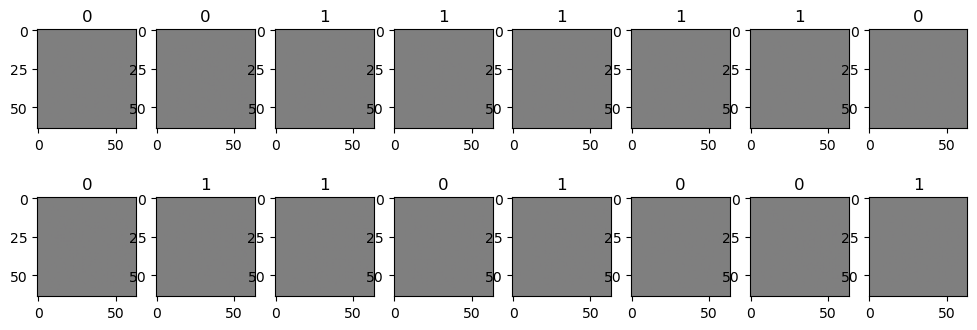

Epoch: 2000
discriminator loss: [tag: 0.07218289375305176, labels: 0.4906376600265503], generator loss: [tag: 7.7909064292907715, labels: 0.08724173903465271]
1/1 [==============================] - 0s 18ms/step


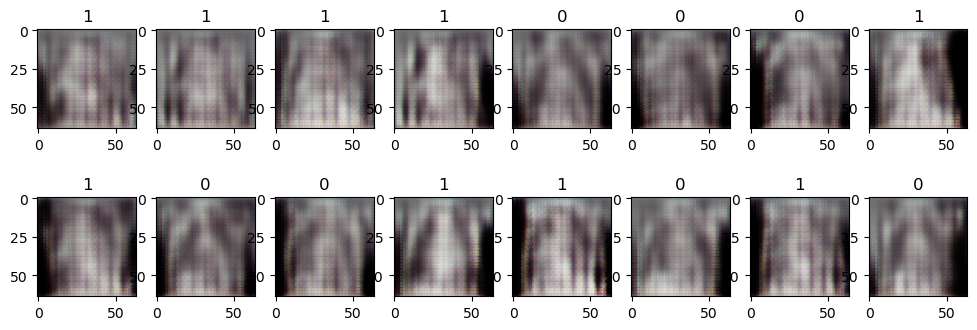

Epoch: 4000
discriminator loss: [tag: -0.10580086708068848, labels: 0.2505508065223694], generator loss: [tag: -8.222755432128906, labels: 0.1582983285188675]
1/1 [==============================] - 0s 23ms/step


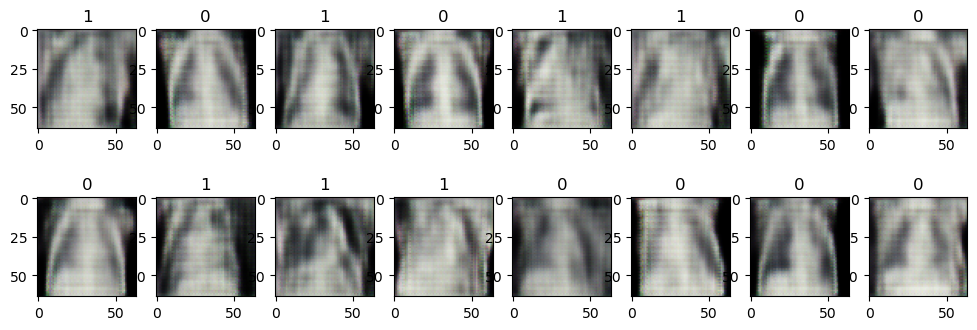

Epoch: 6000
discriminator loss: [tag: -0.0607752799987793, labels: 0.13154669106006622], generator loss: [tag: 5.641670227050781, labels: 0.021251555532217026]
1/1 [==============================] - 0s 20ms/step


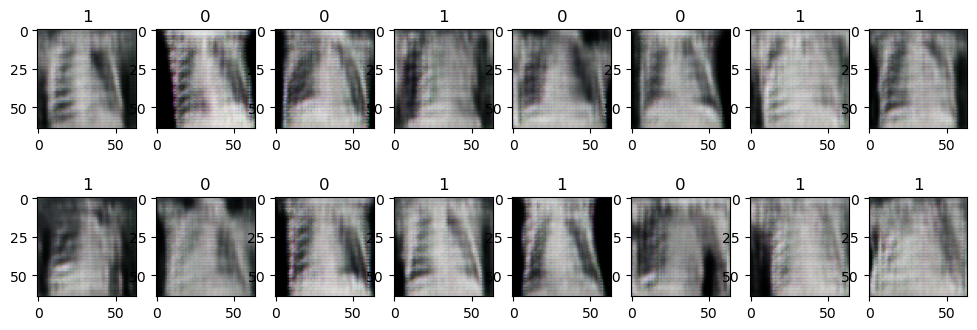

Epoch: 8000
discriminator loss: [tag: 0.129675030708313, labels: 0.07137084007263184], generator loss: [tag: 2.2869231700897217, labels: 0.013490251265466213]
1/1 [==============================] - 0s 17ms/step


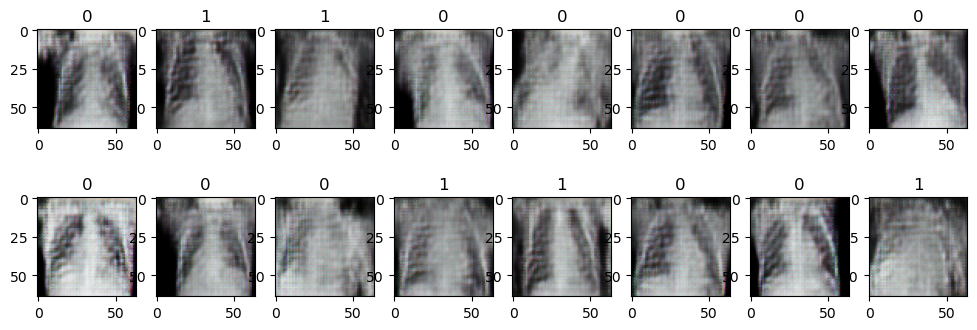

Epoch: 10000
discriminator loss: [tag: -0.049581170082092285, labels: 0.07693598419427872], generator loss: [tag: 0.876426100730896, labels: 0.01049380749464035]
1/1 [==============================] - 0s 18ms/step


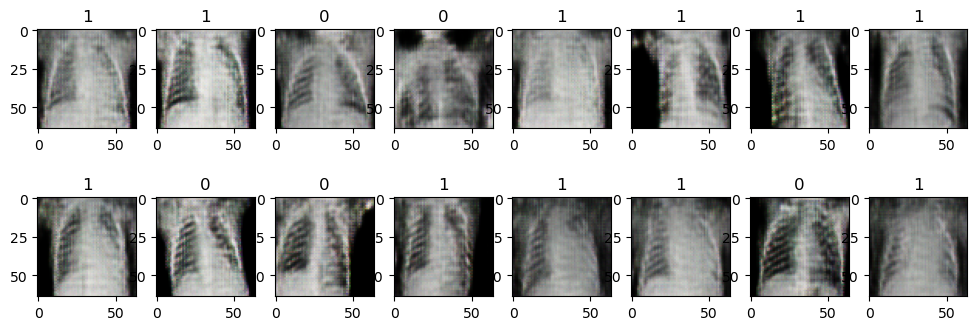

Epoch: 12000
discriminator loss: [tag: 0.04186171293258667, labels: 0.07052608579397202], generator loss: [tag: 0.7866160869598389, labels: 0.008002011105418205]
1/1 [==============================] - 0s 17ms/step


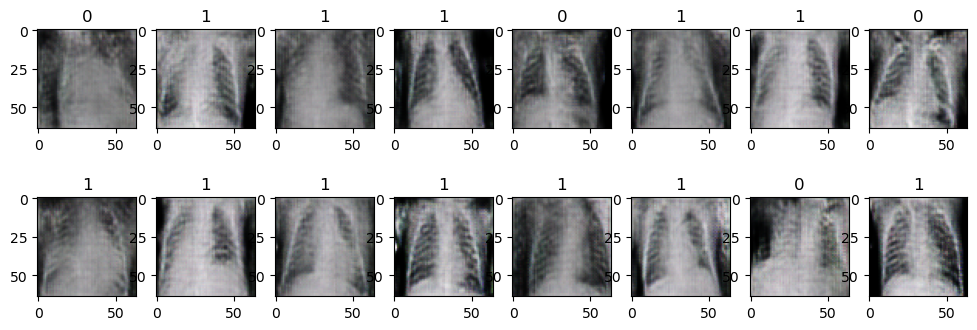

Epoch: 14000
discriminator loss: [tag: -0.07250964641571045, labels: 0.05374316871166229], generator loss: [tag: 0.9781538248062134, labels: 0.007380657829344273]
1/1 [==============================] - 0s 18ms/step


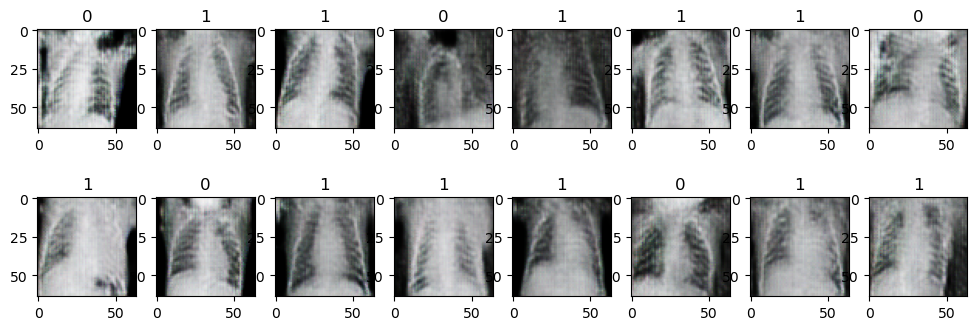

Epoch: 16000
discriminator loss: [tag: 0.11474135518074036, labels: 0.05018257349729538], generator loss: [tag: 0.9403800964355469, labels: 0.0022674784995615482]
1/1 [==============================] - 0s 17ms/step


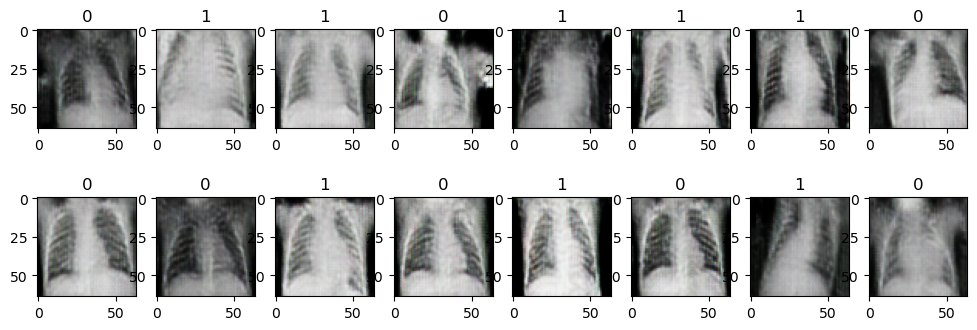

Epoch: 18000
discriminator loss: [tag: 0.09038370847702026, labels: 0.06910467892885208], generator loss: [tag: 1.7734918594360352, labels: 0.019120264798402786]
1/1 [==============================] - 0s 17ms/step


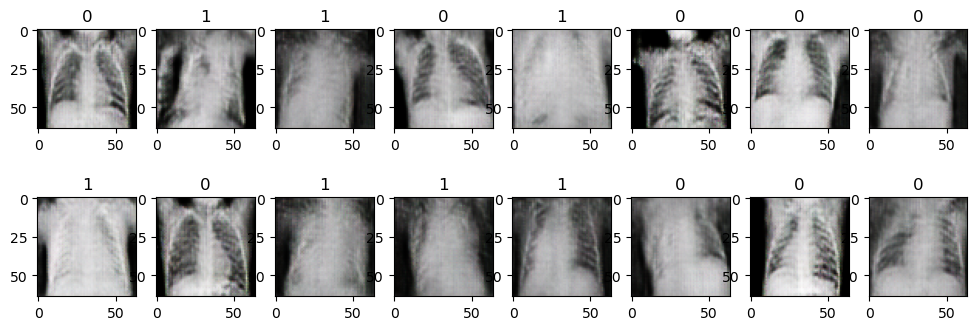

Epoch: 20000
discriminator loss: [tag: -0.08150279521942139, labels: 0.05535641312599182], generator loss: [tag: 1.4318768978118896, labels: 0.01948808692395687]
1/1 [==============================] - 0s 18ms/step


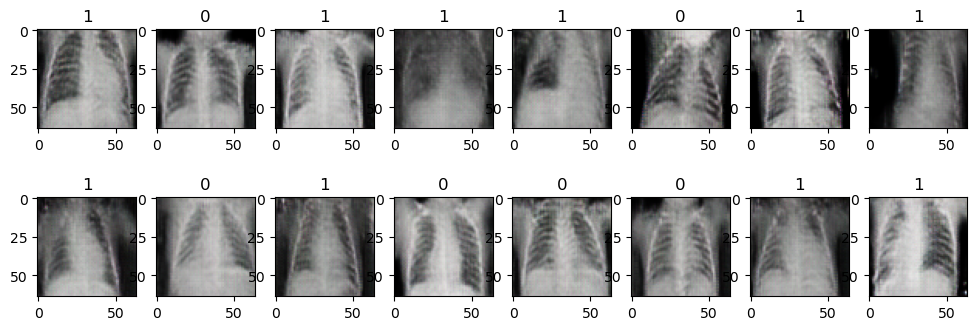

Epoch: 22000
discriminator loss: [tag: -0.32988497614860535, labels: 0.04391581565141678], generator loss: [tag: 1.600598931312561, labels: 0.011755767278373241]
1/1 [==============================] - 0s 18ms/step


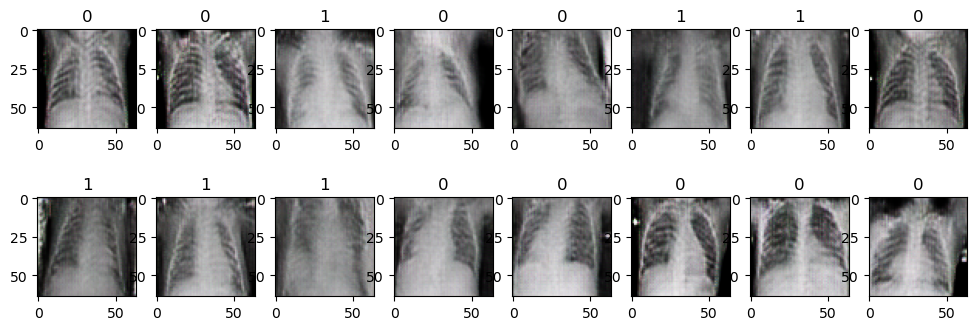

Epoch: 24000
discriminator loss: [tag: 0.07952329516410828, labels: 0.011730347760021687], generator loss: [tag: 1.0505142211914062, labels: 0.011707466095685959]
1/1 [==============================] - 0s 17ms/step


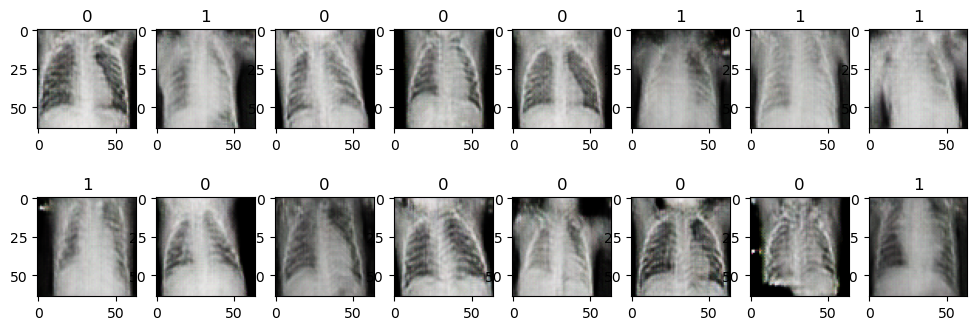

Epoch: 26000
discriminator loss: [tag: -0.15806317329406738, labels: 0.022205129265785217], generator loss: [tag: 1.2138999700546265, labels: 0.026332681998610497]
1/1 [==============================] - 0s 18ms/step


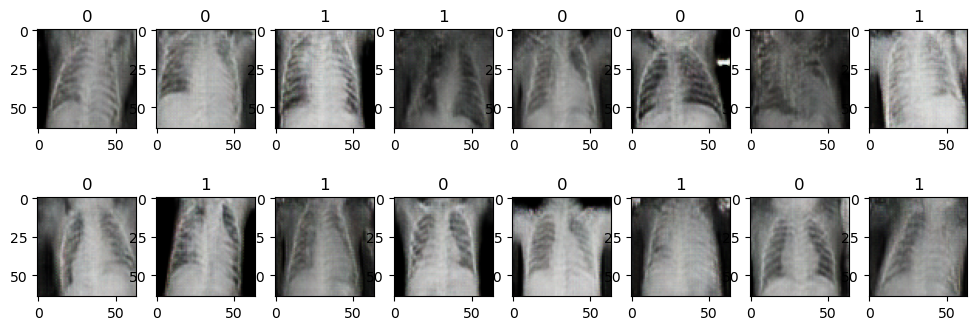

Epoch: 28000
discriminator loss: [tag: -0.17760327458381653, labels: 0.1289009153842926], generator loss: [tag: 1.2574753761291504, labels: 0.06680481135845184]
1/1 [==============================] - 0s 18ms/step


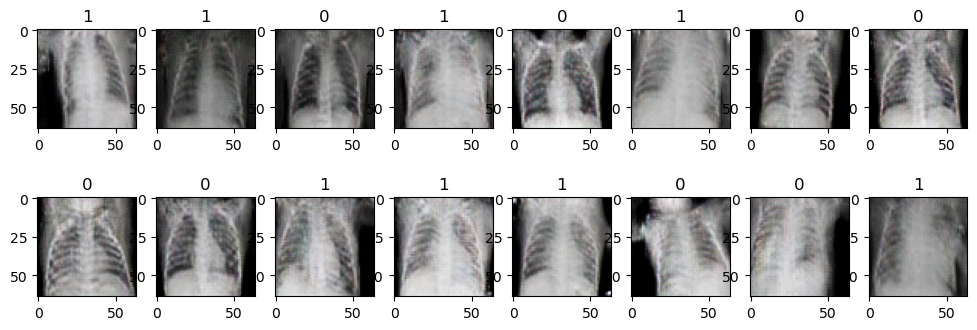

Epoch: 30000
discriminator loss: [tag: -0.2937614321708679, labels: 0.027377614751458168], generator loss: [tag: 0.7818076610565186, labels: 0.008644746616482735]
1/1 [==============================] - 0s 18ms/step


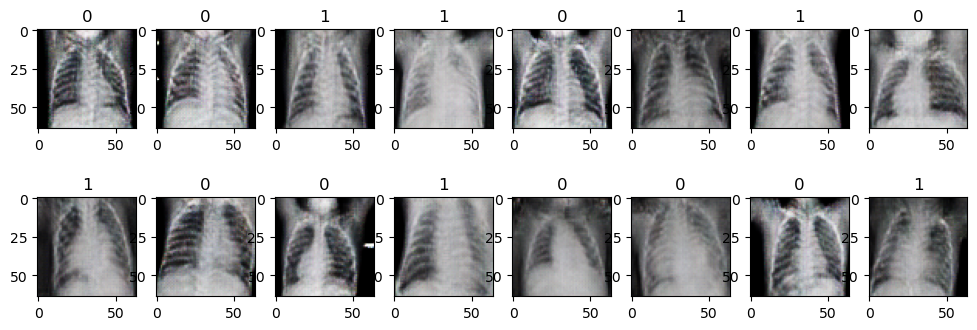

Epoch: 32000
discriminator loss: [tag: -0.18355554342269897, labels: 0.062454283237457275], generator loss: [tag: 2.602675199508667, labels: 0.04071658104658127]
1/1 [==============================] - 0s 19ms/step


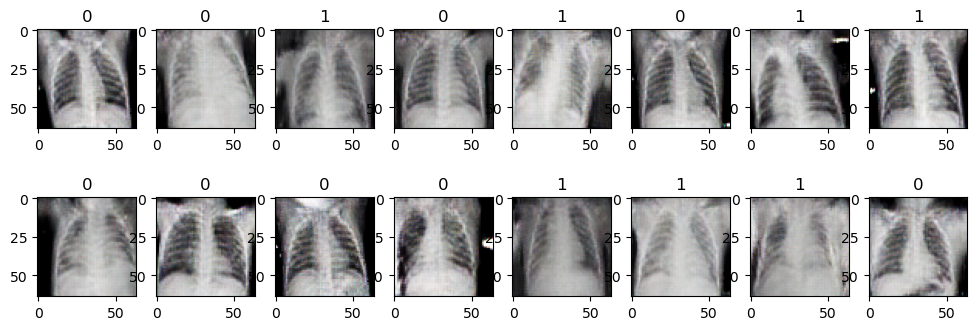

Epoch: 34000
discriminator loss: [tag: -0.15411067008972168, labels: 0.0025251733604818583], generator loss: [tag: 2.3551838397979736, labels: 0.0019827804062515497]
1/1 [==============================] - ETA: 0s

In [ ]:
acwgan.trainAlgorithm(G, D, GAN)

In [ ]:
G.save('/kaggle/working/generator.h5')

In [27]:
G = tf.keras.models.load_model('/kaggle/input/generator1/generator_32bs_32kepoch.h5')

- We have to make sure that the images that the generator generates are correct, and that they actually include pathological conditions, and this is done by generating a large number of samples, using a neural network to classify the images, and then using the trained neural network, in order to classify the basic images that are included in the basic dataset.

In [28]:
datasetGenerationSize = 30000
noize = tf.random.uniform(shape = (datasetGenerationSize, 100), minval = -1, maxval = 1)
newlabels = tf.keras.utils.to_categorical(np.random.choice([0, 1], size = (datasetGenerationSize, )), num_classes = 2)

In [29]:
noize.shape, newlabels.shape

(TensorShape([30000, 100]), (30000, 2))

In [30]:
np.unique(np.argmax(newlabels, axis = 1), return_counts = True)

(array([0, 1]), array([15134, 14866]))

In [31]:
imagesGeneration = G.predict([noize, newlabels])
imagesGeneration.shape

938/938 [==============================] - 15s 16ms/step


(30000, 64, 64, 3)

- Samples generated by the generator for each case (healthy person, person with pneumonia).

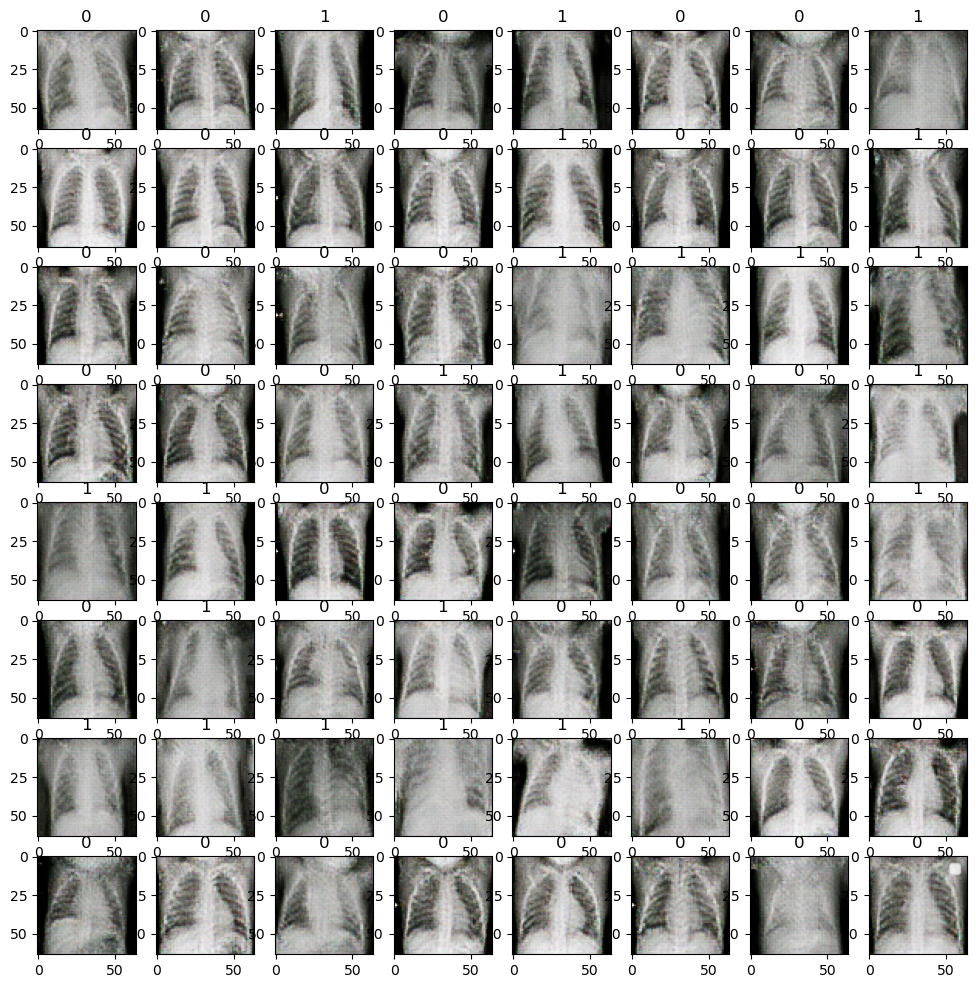

In [32]:
plt.figure(figsize = (12, 12))
t = np.argmax(newlabels, axis = 1)
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(imagesGeneration[i])
    plt.title(t[i])
plt.legend()

In order to be able to evaluate the images generated by the generating neural network, we can do so by proposing a neural structure dedicated to classifying the images generated by the generating neural network, and then we return to the basic images included in the dataset, and we evaluate the performance of the classified neural network that It was trained on the generated images, in order to see if the learned characteristics of the generated images can give high results on the basic images included in the dataset.

In [33]:
# basemodel = tf.keras.applications.VGG16(weights = None, input_shape = (64, 64, 3),
#                                         pooling = 'max', include_top = False)
# x = layers.Dropout(0.4)(basemodel.output)
# x = layers.Dense(128,)(x)
# x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU(alpha = 0.2)(x)
# x = layers.Dropout(0.4)(x)
# x = layers.Dense(32,)(x)
# x = layers.BatchNormalization()(x)
# x = layers.LeakyReLU(alpha = 0.2)(x)
# x = layers.Dropout(0.4)(x)
# x = layers.Dense(1, activation = 'sigmoid')(x)
# m = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
# m.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001))
# m.summary()

In [34]:
import tensorflow as tf
from tensorflow.keras import layers

def residual_block(x, filters, strides=1, downsample=False):
    identity = x

    x = layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if downsample:
        identity = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(identity)
        identity = layers.BatchNormalization()(identity)

    x = layers.add([x, identity])
    x = layers.ReLU()(x)
    return x

def build_resnet18(input_shape=(64, 64, 3), num_classes=1):
    input_layer = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(x, filters=64, downsample=False)
    x = residual_block(x, filters=64, downsample=False)
    x = residual_block(x, filters=128, downsample=True)
    x = residual_block(x, filters=128, downsample=False)
    x = residual_block(x, filters=256, downsample=True)
    x = residual_block(x, filters=256, downsample=False)
    x = residual_block(x, filters=512, downsample=True)
    x = residual_block(x, filters=512, downsample=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(32)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.4)(x)

    output = layers.Dense(num_classes, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model

# Load ResNet18-based model
m = build_resnet18()

# Compile the model
m.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001))

# Print model summary
m.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_40 (Conv2D)             (None, 32, 32, 64)   9472        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_44 (BatchN  (None, 32, 32, 64)  256         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_34 (ReLU)                (None, 32, 32, 64)   0           ['batch_normalization_44[0]

Training the neural network to classify the images generated by the generator.

In [35]:
history = m.fit(imagesGeneration, np.argmax(newlabels, axis = 1),
                epochs = 60, batch_size = 64,
                validation_split = 0.2,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss', mode = 'min',
                                                              restore_best_weights = True)])

Epoch 1/60
375/375 [==============================] - 56s 105ms/step - loss: 0.1908 - val_loss: 2.8665
Epoch 2/60
375/375 [==============================] - 38s 102ms/step - loss: 0.0826 - val_loss: 0.1245
Epoch 3/60
375/375 [==============================] - 38s 102ms/step - loss: 0.0634 - val_loss: 0.0605
Epoch 4/60
375/375 [==============================] - 38s 102ms/step - loss: 0.0522 - val_loss: 0.0429
Epoch 5/60
375/375 [==============================] - 38s 102ms/step - loss: 0.0448 - val_loss: 0.0346
Epoch 6/60
375/375 [==============================] - 38s 102ms/step - loss: 0.0382 - val_loss: 0.0273
Epoch 7/60
375/375 [==============================] - 38s 102ms/step - loss: 0.0350 - val_loss: 0.0406
Epoch 8/60
375/375 [==============================] - 38s 102ms/step - loss: 0.0322 - val_loss: 0.0250
Epoch 9/60
375/375 [==============================] - 38s 102ms/step - loss: 0.0308 - val_loss: 0.0521
Epoch 10/60
375/375 [==============================] - 38s 102ms/step - l

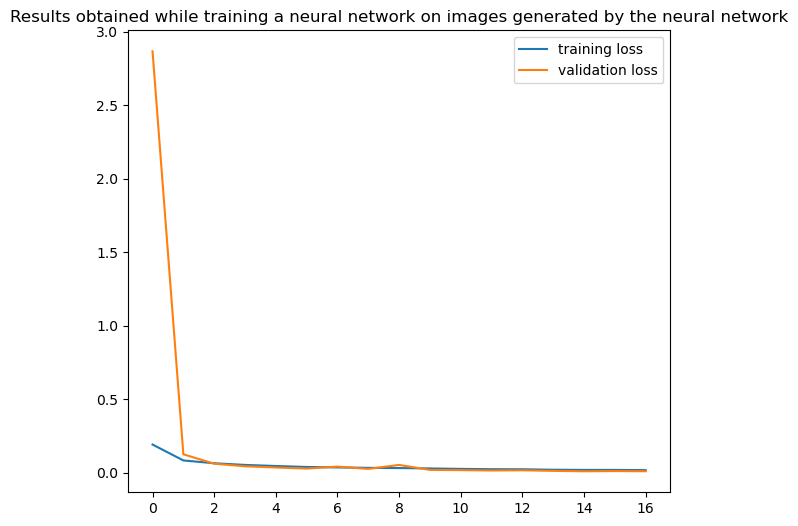

In [36]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

Now, after training on the images generated by the generator, we will test the neural network on the basic images included in the dataset.
We will use several measures in the evaluation to study what is the ability of the generative adversarial network to capture the basic features that characterize each class, and whether the second classified network extracted the features included in the generated images.
Are the attributes that were extracted from the images generated by the generator, can be used on the original images included in the dataset.
This helps in the ability to study what was actually generated, and whether the focus was really on the cases that the X-ray images made him have pneumonia or not.

In [37]:
m.evaluate(images, labels)

163/163 [==============================] - 3s 16ms/step - loss: 0.2960


0.29599952697753906

In [38]:
y_pred = tf.squeeze(m.predict(images))
y_pred.shape

163/163 [==============================] - 3s 14ms/step


TensorShape([5216])

In [39]:
y_pred = y_pred >= 0.5
y_pred = np.array(y_pred, dtype = 'int32')
y_pred

array([0, 0, 0, ..., 0, 1, 1], dtype=int32)

In [40]:
accuracy_score(y_pred, labels)*100

88.49693251533742

In [41]:
print(classification_report(y_pred, labels))

              precision    recall  f1-score   support

           0       0.97      0.70      0.81      1859
           1       0.86      0.99      0.92      3357

    accuracy                           0.88      5216
   macro avg       0.91      0.84      0.86      5216
weighted avg       0.90      0.88      0.88      5216



In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred, labels)
cm

array([[1300,  559],
       [  41, 3316]])

In [43]:
import pandas as pd
cmObject = pd.DataFrame(cm , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
cmObject.head()

NORMAL  PNEUMONIA
NORMAL       1300        559
PNEUMONIA      41       3316

In [44]:
print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_pred, labels)*100,
                                                                   recall_score(y_pred, labels)*100,
                                                                   precision_score(y_pred, labels)*100))

f1_score: 91.70353982300885, recall_score: 98.77867143282693, precision_score: 85.5741935483871


<Axes: >

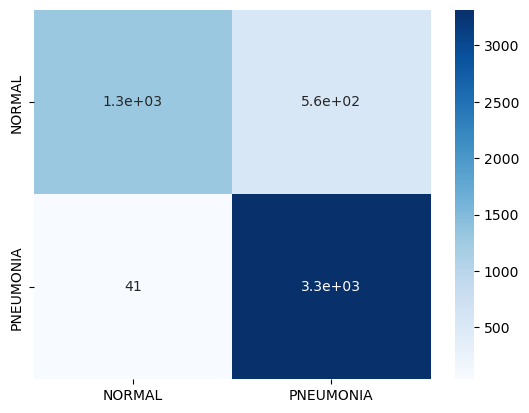

In [45]:
sns.heatmap(cmObject, annot = True, cmap="Blues")

In the end, we can see that we have reached a neural network that is able to generate accurate images. But the slight variation in the accuracy of the classification for each class is due to the fact that we need more training time for the generative adversarial network, which helps to focus more on the characteristics of each class (because the number of samples in the basic dataset is different for each class (the healthy case, pneumonia)).